<a href="https://colab.research.google.com/github/KhrTim/AI-application-systems/blob/main/Weekly_sessions/week11/week_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

url = "https://raw.githubusercontent.com/NVDLI/LDL/main/pt_framework/utilities.py"
r = requests.get(url)

with open('utilities.py', 'w') as f:
  f.write(r.text)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = "book_store_sales.csv"


In [ ]:
def readfile(file_name):
  file = open(file_name, 'r', encoding='utf-8')
  next(file)
  data = []
  for line in (file):
    values = line.split(',')
    data.append(float(values[1]))
  file.close()
  return np.array(data, dtype=np.float32)

## Read data and split up into train and test data.

In [ ]:
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

## Plot dataset

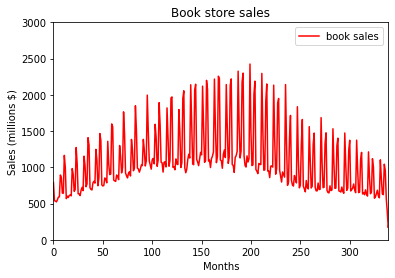

In [ ]:
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title("Book store sales")
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel("Months")
plt.ylabel("Sales (millions $)")
plt.legend()
plt.show()


## Plot naive prediction

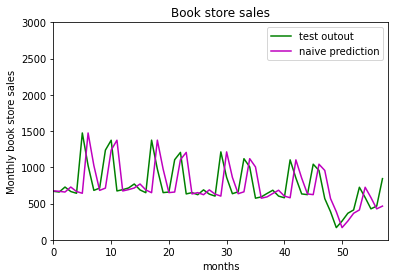

In [ ]:
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test outout')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title("Book store sales")
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()


In [ ]:
# Standartize train and test data.
# Use only training sessions to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev


In [ ]:
# Create train examples
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1,1), dtype=np.float32)
train_y = np.zeros((train_months-MIN,1), dtype=np.float32)
for i in range(0, train_months-MIN):
  train_X[i, -(i+MIN):, 0] = train_sales_std[0: i+MIN]
  train_y[i, 0] = train_sales_std[i+MIN]

# Create test examples
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1,1), dtype=np.float32)
test_y = np.zeros((test_months-MIN,1), dtype=np.float32)
for i in range(0, test_months-MIN):
  test_X[i, -(i+MIN):, 0] = test_sales_std[0: i+MIN]
  test_y[i, 0] = test_sales_std[i+MIN]

# Create Dataset objects
trainset = TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_y))
testset = TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))



In [ ]:
# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn.Module):
  def forward(self, inputs):
    return inputs[1][0]

# Create RNN model
model = nn.Sequential(
    nn.RNN(1,128, nonlinearity='relu', batch_first=True),
    LastTimestep(),
    nn.Linear(128, 1)
)

# Loss function and optimizer
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

# Train model
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset, optimizer,
            loss_function, "mae")

Epoch 1/100 loss: 0.9503 - mae: 0.7276 - val_loss: 1.0744 - val_mae: 0.8103
Epoch 2/100 loss: 0.8286 - mae: 0.6564 - val_loss: 0.7718 - val_mae: 0.6931
Epoch 3/100 loss: 0.6607 - mae: 0.5650 - val_loss: 0.3671 - val_mae: 0.4193
Epoch 4/100 loss: 0.5910 - mae: 0.5840 - val_loss: 0.4126 - val_mae: 0.4872
Epoch 5/100 loss: 0.4942 - mae: 0.5088 - val_loss: 0.3080 - val_mae: 0.3717
Epoch 6/100 loss: 0.4465 - mae: 0.4772 - val_loss: 0.3371 - val_mae: 0.3796
Epoch 7/100 loss: 0.4522 - mae: 0.5055 - val_loss: 0.2665 - val_mae: 0.3624
Epoch 8/100 loss: 0.4665 - mae: 0.4934 - val_loss: 0.2360 - val_mae: 0.3186
Epoch 9/100 loss: 0.4013 - mae: 0.4579 - val_loss: 0.4875 - val_mae: 0.4609
Epoch 10/100 loss: 0.4221 - mae: 0.4789 - val_loss: 0.2955 - val_mae: 0.4017
Epoch 11/100 loss: 0.3608 - mae: 0.4372 - val_loss: 0.2823 - val_mae: 0.3291
Epoch 12/100 loss: 0.3923 - mae: 0.4728 - val_loss: 0.2485 - val_mae: 0.3119
Epoch 13/100 loss: 0.4326 - mae: 0.4901 - val_loss: 0.2620 - val_mae: 0.3873
Epoch 14

[0.10432811760727097, 0.12058749422430992]

In [ ]:
# Create naive prediction based on standardized data
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print("naive test mse: ", mean_squared_error)
print("naive test mean abs: ", mean_abs_error)

naive test mse:  0.4723033
naive test mean abs:  0.48052385


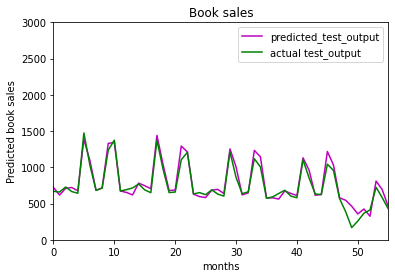

In [ ]:
# Use trained model to predict the test data
inputs = torch.from_numpy(test_X)
inputs = inputs.to(device)
outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()

# De-standardize output
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plot test prediction
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-', 
         label = "predicted_test_output")
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
         'g-', label="actual test_output")
plt.title("Book sales")
plt.axis([0,55,0.0,3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()